In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk

import matplotlib.pyplot as plt # Pour d'éventuelles visualisations
import seaborn as sns # Pour d'éventuelles visualisations

# Téléchargement initial des ressources NLTK (à faire une fois par environnement)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


# Pour Word2Vec
from gensim.models import Word2Vec

# Pour les Réseaux de Neurones avec Keras (TensorFlow backend)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, GlobalAveragePooling1D, Dropout, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Pour les Transformers (Hugging Face)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import evaluate

# Configuration
SEED = 42 # Pour la reproductibilité
np.random.seed(SEED)
tf.random.set_seed(SEED)
# torch.manual_seed(SEED) # Si vous utilisez PyTorch plus directement

# Affichage des dataframes
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wassim/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 1. Chargement et Préparation des Données

Le dataset utilisé est "TimKoornstra/financial-tweets-sentiment" de Hugging Face, contenant des tweets financiers avec des labels de sentiment (positif, négatif, neutre).

In [4]:
print("--- 1. Chargement et Préparation des Données ---")
import pandas as pd
try:
    # Assurez-vous d'être connecté à Hugging Face si le dataset est privé ou nécessite une authentification
    # from huggingface_hub import notebook_login
    # notebook_login() # Décommentez si nécessaire
    df = pd.read_parquet("hf://datasets/TimKoornstra/financial-tweets-sentiment/data/train-00000-of-00001.parquet")
except Exception as e:
    print(f"Erreur de chargement du dataset depuis Hugging Face: {e}")
    print("Utilisation d'un dataset d'exemple simplifié.")
    # Fallback dataset pour les tests hors ligne ou si le chargement échoue
    data_dict = {
        'tweet': [
            "Stock market is soaring with $AAPL!", "This company $XYZ is doing great.", "I am neutral about this $TSLA.",
            "Feeling bearish about the economy.", "Lost a lot of money today with $GME.", "This is a disaster for $BTC.",
            "Positive news for $MSFT.", "Neutral stance on $AMZN.", "Negative outlook for $NVDA.",
            "Great earnings report from $GOOG.", "Uncertainty looms over the $SPX index.", "Significant drop in $OIL prices."
        ] * 100, # Multiplier pour avoir plus de données
        'sentiment': [1, 1, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2] * 100
    }
    df = pd.DataFrame(data_dict)

if 'url' in df.columns:
    df.drop(columns=['url'], inplace=True)
df.rename(columns={'sentiment': 'label_orig_int'}, inplace=True)
df.rename(columns={'tweet': 'text'}, inplace=True)

map_labels_str = {0: "neutral", 1: 'positive',  2: 'negative'}
df['label'] = df['label_orig_int'].apply(lambda x: map_labels_str.get(x, "unknown")) # .get pour gérer les labels inconnus

# Supprimer les lignes avec des labels "unknown" si elles existent
df = df[df['label'] != "unknown"]
df.reset_index(drop=True, inplace=True)

print("Dataset chargé.")

--- 1. Chargement et Préparation des Données ---
Dataset chargé.


Aperçu du DataFrame:


,text,label_orig_int,label
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,2,negative
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,2,negative
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",2,negative
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,2,negative
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,2,negative



Informations sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38091 entries, 0 to 38090
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            38091 non-null  object
 1   label_orig_int  38091 non-null  int64 
 2   label           38091 non-null  object
dtypes: int64(1), object(2)
memory usage: 892.9+ KB

Distribution des labels:
label
positive    17368
neutral     12181
negative     8542
Name: count, dtype: int64


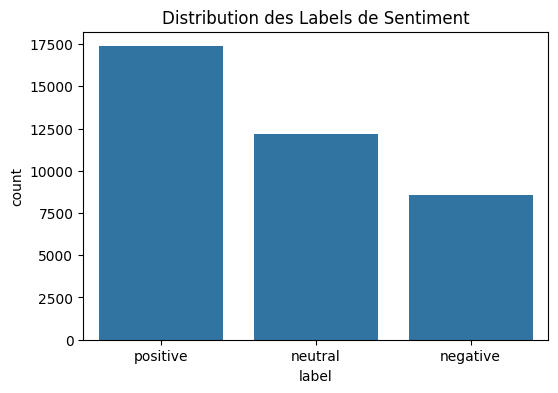

In [5]:
print("Aperçu du DataFrame:")
display(df.head())

print("\nInformations sur le DataFrame:")
df.info()

print("\nDistribution des labels:")
print(df['label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, order = df['label'].value_counts().index)
plt.title('Distribution des Labels de Sentiment')
plt.show()

# 2. Nettoyage du Texte

Les étapes de nettoyage incluent :

    Passage en minuscules.

    Suppression des URLs.

    Suppression des mentions (@) et hashtags (#) (on garde le mot du hashtag).

    Suppression de la ponctuation.

    (Optionnel) Suppression des stop-words (peut être géré par les vectoriseurs).

In [6]:
print("--- 2. Nettoyage du Texte ---")
stop_words_en = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) # Supprime URLs
    text = re.sub(r"\@\w+", "", text) # Supprime mentions
    # text = re.sub(r"#", "", text) # Conserve le mot après le hashtag, supprime juste le #
    text = text.translate(str.maketrans("", "", string.punctuation.replace('$',''))) # Conserve le $ pour les tickers
    text = re.sub(r"\s+", " ", text).strip() # Supprime les espaces multiples
    # Optionnel: suppression des stop words (peut être fait plus tard ou par le vectoriseur)
    # tokens = word_tokenize(text)
    # tokens = [word for word in tokens if word not in stop_words_en and word.isalpha()]
    # text = " ".join(tokens)
    return text

--- 2. Nettoyage du Texte ---


In [7]:
df["cleaned_text"] = df["text"].apply(clean_text)
print("Exemples de texte nettoyé :")
display(df[["text", "cleaned_text"]].head())

Exemples de texte nettoyé :


,text,cleaned_text
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,$bynd jpmorgan reels in expectations on beyond meat
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,$ccl $rcl nomura points to bookings weakness at carnival and royal caribbean
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",$cx cemex cut at credit suisse jp morgan on weak building outlook
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,$ess btig research cuts to neutral
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,$fnko funko slides after piper jaffray pt cut


### 3. Séparation des Données Train/Test

Nous divisons les données en ensembles d'entraînement et de test (80%/20%) en veillant à stratifier par label pour maintenir la proportion des classes.

In [8]:
print("--- 3. Séparation Train/Test ---")
X = df["cleaned_text"]
y_str = df["label"]
y_int = df["label_orig_int"] # Sera utilisé pour les NN et Transformers

# Encoder les labels string en int pour certains modèles sklearn si besoin,
# mais classification_report peut utiliser les strings.
label_encoder_global = LabelEncoder()
y_encoded_for_split = label_encoder_global.fit_transform(y_str)


X_train_text, X_test_text, y_train_str, y_test_str, y_train_int, y_test_int, y_train_encoded, y_test_encoded = train_test_split(
    X, y_str, y_int, y_encoded_for_split, test_size=0.2, random_state=SEED, stratify=y_str
)

print(f"Taille de l'ensemble d'entraînement: {len(X_train_text)}")
print(f"Taille de l'ensemble de test: {len(X_test_text)}")
print(f"Distribution des labels dans y_train_str:\n{y_train_str.value_counts(normalize=True)}")
print(f"Distribution des labels dans y_test_str:\n{y_test_str.value_counts(normalize=True)}")

--- 3. Séparation Train/Test ---
Taille de l'ensemble d'entraînement: 30472
Taille de l'ensemble de test: 7619
Distribution des labels dans y_train_str:
label
positive    0.455960
neutral     0.319802
negative    0.224239
Name: proportion, dtype: float64
Distribution des labels dans y_test_str:
label
positive    0.455965
neutral     0.319727
negative    0.224308
Name: proportion, dtype: float64


# 4. Modèles "Classiques" avec Scikit-learn

Nous allons commencer par évaluer des modèles de classification textuelle plus traditionnels.

In [9]:
results_summary = {}

def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
    print(f"Rapport de Classification pour {model_name}:")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=label_encoder_global.classes_)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_global.classes_, yticklabels=label_encoder_global.classes_)
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

    results_summary[model_name] = {
        'accuracy': accuracy,
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score']
    }

### 4.a. Naive Bayes (Multinomial) avec TF-IDF

Le classifieur Naive Bayes est un modèle probabiliste simple mais souvent efficace pour la classification de texte. Nous utilisons MultinomialNB qui est adapté aux comptes de mots ou fréquences (TF-IDF). 

--- 4.a. Naive Bayes (Multinomial) ---
Rapport de Classification pour Naive Bayes (TF-IDF):
              precision    recall  f1-score   support

    negative       0.67      0.47      0.55      1709
     neutral       0.71      0.68      0.69      2436
    positive       0.69      0.82      0.75      3474

    accuracy                           0.70      7619
   macro avg       0.69      0.66      0.67      7619
weighted avg       0.69      0.70      0.69      7619



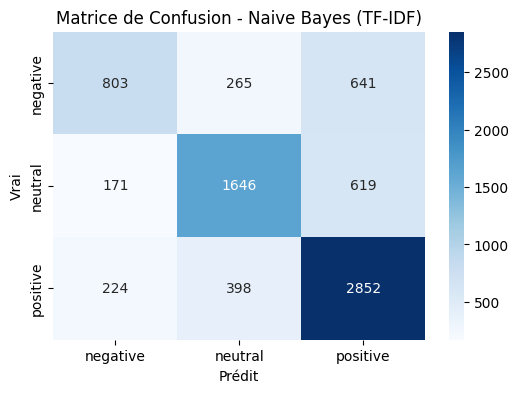

In [10]:
print("--- 4.a. Naive Bayes (Multinomial) ---")
tfidf_vectorizer_nb = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf_nb = tfidf_vectorizer_nb.fit_transform(X_train_text)
X_test_tfidf_nb = tfidf_vectorizer_nb.transform(X_test_text)

nb_model = MultinomialNB(alpha=0.1) # alpha est un hyperparamètre à régler
# GridSearchCV pour Naive Bayes
# params_nb = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
# grid_nb = GridSearchCV(MultinomialNB(), params_nb, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_nb.fit(X_train_tfidf_nb, y_train_str)
# nb_model = grid_nb.best_estimator_
# print(f"Meilleurs paramètres pour Naive Bayes: {grid_nb.best_params_}")
nb_model.fit(X_train_tfidf_nb, y_train_str)

y_pred_nb = nb_model.predict(X_test_tfidf_nb)
evaluate_model("Naive Bayes (TF-IDF)", y_test_str, y_pred_nb)

### 4.b. Régression Logistique avec TF-IDF

La Régression Logistique est un autre modèle linéaire robuste, souvent utilisé comme baseline solide.

--- 4.b. Régression Logistique ---
Rapport de Classification pour Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

    negative       0.64      0.61      0.62      1709
     neutral       0.71      0.75      0.73      2436
    positive       0.77      0.76      0.77      3474

    accuracy                           0.72      7619
   macro avg       0.71      0.71      0.71      7619
weighted avg       0.72      0.72      0.72      7619



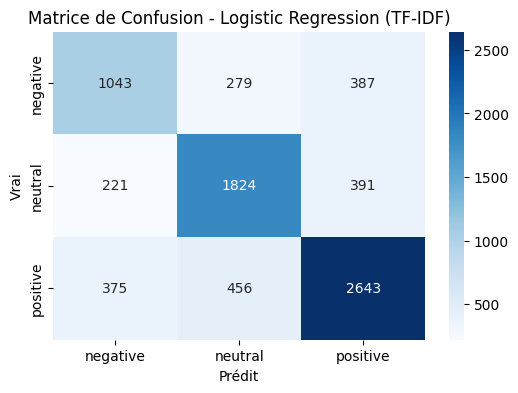

In [11]:
print("--- 4.b. Régression Logistique ---")
# On peut réutiliser le même vectoriseur TF-IDF si les paramètres sont identiques
# ou en créer un spécifique si on veut tester des paramètres différents
tfidf_vectorizer_lr = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf_lr = tfidf_vectorizer_lr.fit_transform(X_train_text)
X_test_tfidf_lr = tfidf_vectorizer_lr.transform(X_test_text)

lr_model = LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', C=1.0, class_weight='balanced')
# GridSearchCV pour Logistic Regression
# params_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
# grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', class_weight='balanced'),
#                        params_lr, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_lr.fit(X_train_tfidf_lr, y_train_str)
# lr_model = grid_lr.best_estimator_
# print(f"Meilleurs paramètres pour Régression Logistique: {grid_lr.best_params_}")
lr_model.fit(X_train_tfidf_lr, y_train_str)

y_pred_lr = lr_model.predict(X_test_tfidf_lr)
evaluate_model("Logistic Regression (TF-IDF)", y_test_str, y_pred_lr)

### 4.c. Random Forest avec TF-IDF

Random Forest est un modèle d'ensemble basé sur les arbres de décision, capable de capturer des interactions non linéaires.

--- 4.c. Random Forest avec Meilleurs Hyperparamètres (issus de RandomizedSearch) ---
Entraînement du Random Forest avec les meilleurs hyperparamètres...
Rapport de Classification pour Random Forest (Best Params):
              precision    recall  f1-score   support

    negative       0.54      0.61      0.57      1709
     neutral       0.66      0.69      0.67      2436
    positive       0.76      0.68      0.72      3474

    accuracy                           0.67      7619
   macro avg       0.65      0.66      0.66      7619
weighted avg       0.68      0.67      0.67      7619



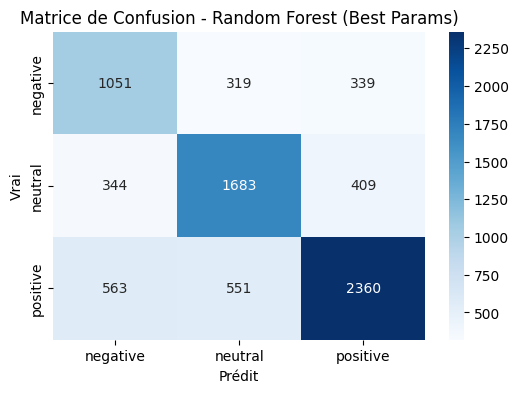

In [12]:
## Cellule Code: Random Forest avec les Meilleurs Hyperparamètres Trouvés

print("--- 4.c. Random Forest avec Meilleurs Hyperparamètres (issus de RandomizedSearch) ---")

# Vectorisation TF-IDF
tfidf_vectorizer_rf_best = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,1))
X_train_tfidf_rf_best = tfidf_vectorizer_rf_best.fit_transform(X_train_text)
X_test_tfidf_rf_best = tfidf_vectorizer_rf_best.transform(X_test_text)

# Meilleurs hyperparamètres trouvés par RandomizedSearchCV 
best_rf_params_found = {
    'bootstrap': False,
    'class_weight': 'balanced',
    'max_depth': None,
    'min_samples_leaf': 8,
    'min_samples_split': 9,
    'n_estimators': 162
}

rf_model_best_params = RandomForestClassifier(
    n_estimators=best_rf_params_found['n_estimators'],
    max_depth=best_rf_params_found['max_depth'],
    min_samples_split=best_rf_params_found['min_samples_split'],
    min_samples_leaf=best_rf_params_found['min_samples_leaf'],
    bootstrap=best_rf_params_found['bootstrap'],
    class_weight=best_rf_params_found['class_weight'],
    random_state=SEED, 
    n_jobs=-1        
)

print("Entraînement du Random Forest avec les meilleurs hyperparamètres...")
rf_model_best_params.fit(X_train_tfidf_rf_best, y_train_str)

# Évaluer le modèle sur le jeu de test
y_pred_rf_best_params = rf_model_best_params.predict(X_test_tfidf_rf_best)
evaluate_model("Random Forest (Best Params)", y_test_str, y_pred_rf_best_params)


# 5. Word2Vec + Classifieur

Word2Vec est une technique pour apprendre des représentations vectorielles (embeddings) de mots. Nous allons entraîner un modèle Word2Vec sur nos données d'entraînement, puis utiliser la moyenne des vecteurs des mots d'un tweet comme feature pour un classifieur.

### 5.a. Entraînement du Modèle Word2Vec

In [13]:
print("--- 5.a. Entraînement de Word2Vec ---")
# Tokeniser les textes pour Word2Vec (nltk.word_tokenize est une option simple)
tokenized_X_train_w2v = [word_tokenize(text) for text in X_train_text]
tokenized_X_test_w2v = [word_tokenize(text) for text in X_test_text]

print(f"Exemple de tweet tokenisé: {tokenized_X_train_w2v[0]}")

--- 5.a. Entraînement de Word2Vec ---
Exemple de tweet tokenisé: ['sterling', 'hits', 'a', 'sevenmonth', 'high', 'as', 'election', 'nears', 'economy', 'marketscreener']


In [14]:
W2V_VECTOR_SIZE = 100 # Dimension des embeddings Word2Vec
W2V_WINDOW = 5      # Taille de la fenêtre de contexte
W2V_MIN_COUNT = 2   # Ignorer les mots avec une fréquence totale inférieure à cela
W2V_WORKERS = 4     # Nombre de threads pour l'entraînement

w2v_model = Word2Vec(sentences=tokenized_X_train_w2v,
                     vector_size=W2V_VECTOR_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=W2V_WORKERS,
                     sg=0, # CBOW (0) ou Skip-gram (1)
                     seed=SEED)

print(f"Modèle Word2Vec entraîné. Taille du vocabulaire: {len(w2v_model.wv.index_to_key)}")

# Sauvegarder le modèle (optionnel)
# w2v_model.wv.save_word2vec_format("word2vec_financial_tweets.bin", binary=True)

Modèle Word2Vec entraîné. Taille du vocabulaire: 17466


In [15]:
# Explorer le modèle Word2Vec (si le vocabulaire est assez grand)
try:
    print("\nMots similaires à 'stock' (si dans le vocabulaire):")
    display(w2v_model.wv.most_similar('stock', topn=5))
except KeyError:
    print("'stock' n'est pas dans le vocabulaire du modèle Word2Vec.")

try:
    print("\nMots similaires à 'market' (si dans le vocabulaire):")
    display(w2v_model.wv.most_similar('market', topn=5))
except KeyError:
    print("'market' n'est pas dans le vocabulaire du modèle Word2Vec.")


Mots similaires à 'stock' (si dans le vocabulaire):


[('characteristics', 0.8676854968070984),
 ('cap', 0.8441227674484253),
 ('bear', 0.8006476759910583),
 ('share', 0.7961100339889526),
 ('100b', 0.7873205542564392)]


Mots similaires à 'market' (si dans le vocabulaire):


[('splits', 0.8844784498214722),
 ('performing', 0.8551607728004456),
 ('split', 0.8290551900863647),
 ('trade', 0.8248071074485779),
 ('bear', 0.8170798420906067)]

### 5.b. Création des Vecteurs de Document et Classification

Nous moyennons les vecteurs Word2Vec des mots de chaque tweet pour obtenir un vecteur de document unique.

In [16]:
def document_vector(doc_tokens, model, num_features):
    # Filtrer les mots hors vocabulaire
    feature_vec = np.zeros((num_features,), dtype="float32")
    num_words = 0
    index2word_set = set(model.wv.index_to_key) # Pour une recherche plus rapide

    for word in doc_tokens:
        if word in index2word_set:
            num_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

In [17]:
X_train_w2v = np.array([document_vector(doc, w2v_model, W2V_VECTOR_SIZE) for doc in tokenized_X_train_w2v])
X_test_w2v = np.array([document_vector(doc, w2v_model, W2V_VECTOR_SIZE) for doc in tokenized_X_test_w2v])

print(f"Shape de X_train_w2v: {X_train_w2v.shape}")
print(f"Shape de X_test_w2v: {X_test_w2v.shape}")

Shape de X_train_w2v: (30472, 100)
Shape de X_test_w2v: (7619, 100)


Rapport de Classification pour Logistic Regression (Word2Vec Avg):
              precision    recall  f1-score   support

    negative       0.39      0.32      0.35      1709
     neutral       0.56      0.67      0.61      2436
    positive       0.64      0.62      0.63      3474

    accuracy                           0.57      7619
   macro avg       0.53      0.53      0.53      7619
weighted avg       0.56      0.57      0.56      7619



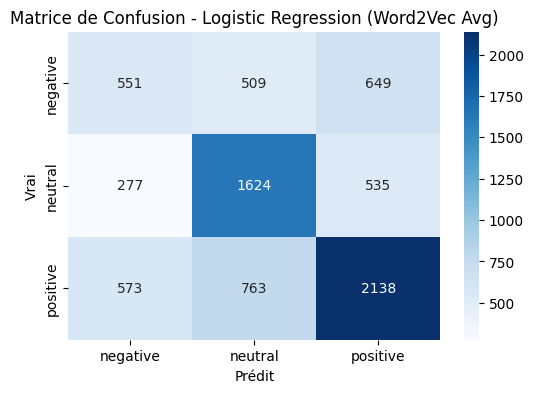

In [18]:
# Utiliser Word2Vec avec une Régression Logistique
lr_w2v_model = LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', C=1.0, class_weight='balanced')
lr_w2v_model.fit(X_train_w2v, y_train_str)

y_pred_lr_w2v = lr_w2v_model.predict(X_test_w2v)
evaluate_model("Logistic Regression (Word2Vec Avg)", y_test_str, y_pred_lr_w2v)

# 6. Réseaux de Neurones avec Keras/TensorFlow

Nous allons maintenant explorer des modèles plus complexes basés sur les réseaux de neurones.

In [19]:
# y_train_encoded et y_test_encoded ont été créés lors du split initial.
# y_train_int et y_test_int sont les labels originaux 0,1,2.
# Pour Keras, nous avons besoin de labels one-hot encodés.

num_classes = len(label_encoder_global.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Shape de y_train_categorical: {y_train_categorical.shape}")
print(f"Exemple de label one-hot: {y_train_categorical[0]} (correspond à '{y_train_str.iloc[0]}')")

Shape de y_train_categorical: (30472, 3)
Exemple de label one-hot: [0. 0. 1.] (correspond à 'positive')


### 6.a. Réseau Feedforward (MLP) avec TF-IDF

Un Perceptron Multi-Couches (MLP) simple utilisant les features TF-IDF.

In [20]:
print("--- 6.a. Réseau Feedforward (MLP) avec TF-IDF ---")
# Utiliser les mêmes Tfidf que pour LR/NB pour la comparaison, ou en créer un nouveau
# Nous réutilisons X_train_tfidf_lr et X_test_tfidf_lr (issus du TfidfVectorizer pour la LR)
X_train_tfidf_dense_mlp = X_train_tfidf_lr.toarray() # Keras MLP préfère les matrices denses
X_test_tfidf_dense_mlp = X_test_tfidf_lr.toarray()

print(f"Shape de X_train_tfidf_dense_mlp: {X_train_tfidf_dense_mlp.shape}")

--- 6.a. Réseau Feedforward (MLP) avec TF-IDF ---
Shape de X_train_tfidf_dense_mlp: (30472, 5000)


/home/wassim/repos/nlp/projet/twitter-sentiment-analysis/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-12 06:28:55.580344: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,579 (2.47 MB)

 Trainable params: 648,579 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-05-12 06:28:55.925484: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548480000 exceeds 10% of free system memory.


857/857 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5564 - loss: 0.9042 - val_accuracy: 0.7116 - val_loss: 0.6704
Epoch 2/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7489 - loss: 0.6139 - val_accuracy: 0.7182 - val_loss: 0.6724
Epoch 3/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7953 - loss: 0.5136 - val_accuracy: 0.7169 - val_loss: 0.7072
Epoch 4/10
857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8325 - loss: 0.4335 - val_accuracy: 0.7198 - val_loss: 0.7606
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
Rapport de Classification pour MLP (TF-IDF):
              precision    recall  f1-score   support

    negative       0.66      0.53      0.59      1709
     neutral       0.72      0.73      0.72      2436
    positive       0.74      0.79      0.76      3474

    accuracy                           0.72      7619
   macro avg       0.70      0.69      0.69      7619
weighted avg       0.71      0.72      0.71      7619



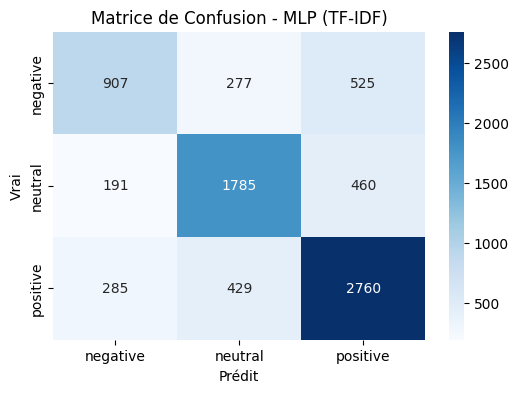

In [21]:
MLP_EPOCHS = 10 # Augmenter pour de meilleurs résultats, mais attention au surapprentissage
MLP_BATCH_SIZE = 32

mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf_dense_mlp.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
mlp_model.summary()

early_stopping_mlp = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mlp = mlp_model.fit(X_train_tfidf_dense_mlp, y_train_categorical,
                            epochs=MLP_EPOCHS,
                            batch_size=MLP_BATCH_SIZE,
                            validation_split=0.1, # Utilise 10% des données d'entraînement pour la validation
                            callbacks=[early_stopping_mlp],
                            verbose=1)

loss_mlp, acc_mlp = mlp_model.evaluate(X_test_tfidf_dense_mlp, y_test_categorical, verbose=0)
y_pred_mlp_probs = mlp_model.predict(X_test_tfidf_dense_mlp)
y_pred_mlp_encoded = np.argmax(y_pred_mlp_probs, axis=1)
y_pred_mlp_str = label_encoder_global.inverse_transform(y_pred_mlp_encoded)

evaluate_model("MLP (TF-IDF)", y_test_str, y_pred_mlp_str)
# Remplacer la valeur d'accuracy par celle obtenue sur le test set si EarlyStopping est utilisé
results_summary["MLP (TF-IDF)"]['accuracy'] = acc_mlp

### 6.b. Réseau Récurrent (LSTM) avec Embeddings

Les LSTM (Long Short-Term Memory) sont bien adaptés au traitement de séquences comme le texte. Nous utiliserons une couche d'embedding apprise conjointement avec le modèle.

In [22]:
print("--- 6.b. Réseau Récurrent (LSTM) ---")
NN_MAX_WORDS = 15000      # Nombre max de mots à garder dans le vocabulaire du Tokenizer Keras
NN_MAX_SEQUENCE_LENGTH = 100 # Longueur max des séquences (tweets)
NN_EMBEDDING_DIM = 100    # Dimension de la couche d'embedding (peut être la même que W2V_VECTOR_SIZE)
LSTM_EPOCHS = 5           # Peut nécessiter plus d'époques, mais attention au temps
LSTM_BATCH_SIZE = 64

--- 6.b. Réseau Récurrent (LSTM) ---


In [23]:
keras_tokenizer = KerasTokenizer(num_words=NN_MAX_WORDS, oov_token="<unk>") # <unk> pour les mots inconnus
keras_tokenizer.fit_on_texts(X_train_text)

X_train_sequences = keras_tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = keras_tokenizer.texts_to_sequences(X_test_text)

X_train_padded = pad_sequences(X_train_sequences, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

word_index_keras = keras_tokenizer.word_index
print(f"Vocabulaire du Tokenizer Keras contient {len(word_index_keras)} mots uniques.")
print(f"Shape de X_train_padded: {X_train_padded.shape}")

Vocabulaire du Tokenizer Keras contient 40361 mots uniques.
Shape de X_train_padded: (30472, 100)


In [24]:
# Optionnel : Utiliser les embeddings Word2Vec pré-entraînés comme poids initiaux pour la couche Embedding
# Cela peut aider si le dataset d'entraînement est petit.

embedding_matrix_lstm = np.zeros((min(NN_MAX_WORDS, len(word_index_keras) + 1), NN_EMBEDDING_DIM))
num_w2v_loaded = 0
for word, i in word_index_keras.items():
    if i >= NN_MAX_WORDS:
        continue
    if word in w2v_model.wv: # Utiliser le w2v_model entraîné précédemment
        embedding_vector = w2v_model.wv[word]
        embedding_matrix_lstm[i] = embedding_vector
        num_w2v_loaded +=1

print(f"{num_w2v_loaded} vecteurs de mots chargés depuis Word2Vec dans la matrice d'embedding LSTM.")

# Si True, les poids de la couche Embedding seront figés (ceux de Word2Vec).
# Si False, ils seront fine-tunés pendant l'entraînement du LSTM.
USE_PRETRAINED_W2V_FOR_LSTM = True
TRAINABLE_EMBEDDING_LSTM = not USE_PRETRAINED_W2V_FOR_LSTM if USE_PRETRAINED_W2V_FOR_LSTM else True

14847 vecteurs de mots chargés depuis Word2Vec dans la matrice d'embedding LSTM.


--- 6.b. Réseau Récurrent (LSTM) - AMÉLIORÉ avec Word2Vec ---
Tokenisation des textes pour le LSTM avec Word2Vec...
Vocabulaire du Tokenizer Keras (pour W2V LSTM) contient 40361 mots uniques.
Shape de X_train_padded (pour W2V LSTM): (30472, 100)
Création de la matrice d'embedding à partir de votre modèle Word2Vec...
14847 vecteurs de mots chargés depuis VOTRE Word2Vec dans la matrice d'embedding LSTM.
Calcul des poids des classes pour la fonction de perte...
Poids des classes calculés (pour W2V LSTM): {0: 1.4865115371481536, 1: 1.0423122969043954, 2: 0.73105897029893}
Définition de l'architecture du modèle LSTM amélioré...
Résumé du modèle LSTM amélioré:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embedding (Embedding)      │ (None, 100, 100)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 100, 256)       │       234,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_intermediate (Dense)      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,907,299 (7.28 MB)

 Trainable params: 1,907,299 (7.28 MB)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement du modèle LSTM amélioré avec Word2Vec...
Epoch 1/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 78s 167ms/step - accuracy: 0.4465 - loss: 1.0969 - val_accuracy: 0.4528 - val_loss: 0.9711 - learning_rate: 0.0010
Epoch 2/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 72s 169ms/step - accuracy: 0.5829 - loss: 0.8801 - val_accuracy: 0.6660 - val_loss: 0.7454 - learning_rate: 0.0010
Epoch 3/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.7390 - loss: 0.6295 - val_accuracy: 0.7080 - val_loss: 0.7610 - learning_rate: 0.0010
Epoch 4/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8217 - loss: 0.4732
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
429/429 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.8217 - loss: 0.4732 - val_accuracy: 0.7208 - val_loss: 0.8253 - learning_rate: 0.0010
Epoch 5/15
429/429 ━━━━━━━━━━━━━━━━━━━━ 71s 165ms/step - accuracy: 0.8695 - loss: 0.3607 - val_accuracy: 0.7323 - val_loss: 0.8774 - learning_rate: 2.0000e-04
Ep

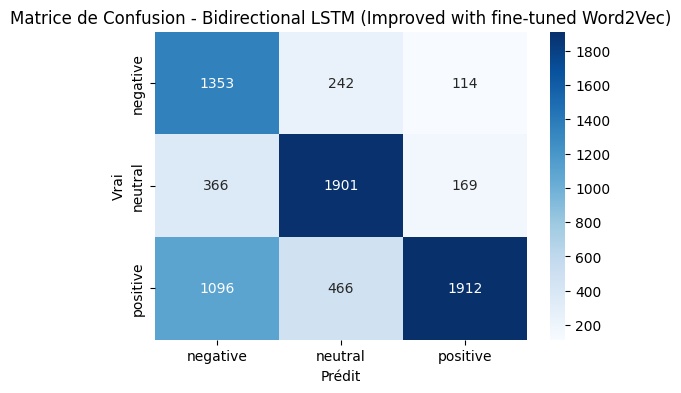

Analyse du LSTM amélioré avec Word2Vec terminée.


In [25]:
print("--- 6.b. Réseau Récurrent (LSTM) - AMÉLIORÉ avec Word2Vec ---")

# --- Paramètres Configurables ---
# Ces paramètres sont essentiels pour la performance et la reproductibilité.
# NN_MAX_WORDS: Taille maximale du vocabulaire à considérer par le Tokenizer Keras.
# NN_MAX_SEQUENCE_LENGTH: Longueur à laquelle toutes les séquences de mots (tweets) seront paddées ou tronquées.
# NN_EMBEDDING_DIM: Dimension des vecteurs d'embedding (doit correspondre à la dimension de vos embeddings Word2Vec).
# LSTM_EPOCHS_IMPROVED_W2V: Nombre maximal d'époques pour l'entraînement. EarlyStopping peut l'arrêter plus tôt.
# LSTM_BATCH_SIZE_IMPROVED_W2V: Nombre d'échantillons par mise à jour des poids du gradient.
# LSTM_LEARNING_RATE_W2V: Taux d'apprentissage initial pour l'optimiseur Adam.

# Assurez-vous que ces constantes sont définies à partir de vos étapes précédentes.
# Exemple de valeurs typiques (adaptez si vos variables ont d'autres noms ou valeurs):
# NN_MAX_WORDS = 15000 (valeur utilisée précédemment pour Keras Tokenizer)
# NN_MAX_SEQUENCE_LENGTH = 100 (valeur utilisée précédemment pour le padding)
# NN_EMBEDDING_DIM = 100 (si W2V_VECTOR_SIZE était 100)

LSTM_EPOCHS_IMPROVED_W2V = 15
LSTM_BATCH_SIZE_IMPROVED_W2V = 64
LSTM_LEARNING_RATE_W2V = 0.001

# --- Vérification des variables prérequises ---
# Ce code suppose que les variables suivantes sont déjà définies et chargées
# à partir des étapes précédentes de votre notebook :
# - X_train_text, X_test_text: Textes nettoyés pour l'entraînement et le test.
# - y_train_encoded, y_test_encoded: Labels encodés numériquement (ex: 0, 1, 2) pour l'entraînement et le test.
# - y_train_categorical, y_test_categorical: Labels one-hot encodés pour l'entraînement et le test.
# - label_encoder_global: L'instance de LabelEncoder fittée sur vos labels string.
# - num_classes: Le nombre de classes de sentiment uniques.
# - w2v_model: Votre modèle Gensim Word2Vec entraîné.
# - SEED: La graine aléatoire pour la reproductibilité.

# --- Tokenisation Keras (si non déjà faite ou pour s'assurer de la cohérence) ---
# Si X_train_padded, X_test_padded, word_index_keras sont déjà définis avec les bons paramètres,
# vous pouvez sauter cette re-tokenisation. Sinon, il est crucial de la refaire ici
# pour s'assurer que le word_index correspond à embedding_matrix_lstm.

print("Tokenisation des textes pour le LSTM avec Word2Vec...")
keras_tokenizer_w2v_imp = KerasTokenizer(num_words=NN_MAX_WORDS, oov_token="<unk>") # oov_token gère les mots hors vocabulaire
keras_tokenizer_w2v_imp.fit_on_texts(X_train_text)
word_index_keras = keras_tokenizer_w2v_imp.word_index # Remplacer l'ancien word_index si vous re-tokenisez

X_train_sequences_w2v_imp = keras_tokenizer_w2v_imp.texts_to_sequences(X_train_text)
X_test_sequences_w2v_imp = keras_tokenizer_w2v_imp.texts_to_sequences(X_test_text)

# Remplacer X_train_padded et X_test_padded par les nouvelles séquences paddées
X_train_padded = pad_sequences(X_train_sequences_w2v_imp, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences_w2v_imp, maxlen=NN_MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulaire du Tokenizer Keras (pour W2V LSTM) contient {len(word_index_keras)} mots uniques.")
print(f"Shape de X_train_padded (pour W2V LSTM): {X_train_padded.shape}")


# --- Création de la Matrice d'Embedding Word2Vec ---
# Cette matrice sert à initialiser les poids de la couche Embedding du LSTM.
# Elle mappe les indices de mots du Tokenizer Keras aux vecteurs de votre modèle Word2Vec.
print("Création de la matrice d'embedding à partir de votre modèle Word2Vec...")
embedding_matrix_lstm = np.zeros((min(NN_MAX_WORDS, len(word_index_keras) + 1), NN_EMBEDDING_DIM))
num_w2v_loaded_in_matrix = 0
for word, i in word_index_keras.items():
    if i >= NN_MAX_WORDS: # Ne considérer que les mots dans la limite du vocabulaire du Tokenizer
        continue
    if word in w2v_model.wv: # Vérifier si le mot existe dans le vocabulaire Word2Vec
        embedding_vector = w2v_model.wv[word]
        embedding_matrix_lstm[i] = embedding_vector # Assigner le vecteur
        num_w2v_loaded_in_matrix +=1
print(f"{num_w2v_loaded_in_matrix} vecteurs de mots chargés depuis VOTRE Word2Vec dans la matrice d'embedding LSTM.")


# --- Calcul des Poids des Classes ---
# Utile pour les datasets déséquilibrés. Cela donne plus de poids dans la fonction de perte
# aux erreurs faites sur les classes minoritaires.
print("Calcul des poids des classes pour la fonction de perte...")
class_weights_values_w2v = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded), # Utilise les labels encodés numériquement
    y=y_train_encoded
)
class_weights_dict_w2v = dict(enumerate(class_weights_values_w2v))
print(f"Poids des classes calculés (pour W2V LSTM): {class_weights_dict_w2v}")


# --- Définition du Modèle LSTM Amélioré avec vos Word2Vec ---
print("Définition de l'architecture du modèle LSTM amélioré...")
lstm_model_improved_w2v = Sequential([
    # Couche d'Input explicite (bonne pratique, aide Keras à construire le modèle tôt)
    Input(shape=(NN_MAX_SEQUENCE_LENGTH,), name="input_sequence"),

    # Couche d'Embedding
    # input_dim: Taille du vocabulaire (+1 pour le padding/OOV si l'indice 0 est utilisé).
    # output_dim: Dimension des vecteurs d'embedding.
    # weights: Initialise les poids avec la matrice Word2Vec pré-calculée.
    # trainable=True: TRÈS IMPORTANT! Permet au réseau d'ajuster (fine-tuner) ces embeddings
    #                 Word2Vec pendant l'entraînement pour les adapter à la tâche spécifique.
    Embedding(input_dim=min(NN_MAX_WORDS, len(word_index_keras) + 1),
              output_dim=NN_EMBEDDING_DIM,
              weights=[embedding_matrix_lstm],
              trainable=True, # Fine-tuning des embeddings Word2Vec
              name="word_embedding"
              ),

    # Couches LSTM Bidirectionnelles
    # Bidirectional permet au LSTM de traiter la séquence dans les deux sens (passé et futur).
    # units: Dimension de l'espace de sortie (et de l'état interne).
    # dropout: Taux de dropout pour les connexions linéaires d'entrée.
    # recurrent_dropout: Taux de dropout pour les connexions récurrentes (états).
    # return_sequences=True: Nécessaire si la couche LSTM suivante attend une séquence en entrée.
    Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), name="bidirectional_lstm_1"),
    Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4), name="bidirectional_lstm_2"), # La dernière couche LSTM ne retourne pas de séquence

    # Couche Dense intermédiaire
    # kernel_regularizer: Ajoute une pénalité L2 aux poids pour réduire le surapprentissage.
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name="dense_intermediate"),
    Dropout(0.5, name="dropout_final"), # Dropout avant la couche de sortie

    # Couche de Sortie
    # units: Nombre de classes de sortie.
    # activation='softmax': Pour la classification multi-classe, produit une distribution de probabilité.
    Dense(num_classes, activation='softmax', name="output_softmax")
])

# --- Compilation du Modèle ---
# optimizer: Algorithme pour mettre à jour les poids (Adam est un choix courant).
# loss: Fonction à minimiser (categorical_crossentropy pour la classification multi-classe avec labels one-hot).
# metrics: Métriques à suivre pendant l'entraînement.
optimizer_lstm_w2v = tf.keras.optimizers.Adam(learning_rate=LSTM_LEARNING_RATE_W2V)
lstm_model_improved_w2v.compile(optimizer=optimizer_lstm_w2v,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# --- Affichage du Résumé du Modèle ---
# Maintenant que la couche Input est définie, le summary devrait être complet.
print("Résumé du modèle LSTM amélioré:")
lstm_model_improved_w2v.summary()

# --- Callbacks pour l'Entraînement ---
# EarlyStopping: Arrête l'entraînement si une métrique monitorée (val_loss) ne s'améliore plus
#                après un certain nombre d'époques (patience). Restore_best_weights garde les
#                meilleurs poids trouvés.
# ReduceLROnPlateau: Réduit le taux d'apprentissage si la métrique monitorée stagne.
#                    Cela peut aider le modèle à converger vers un meilleur minimum.
early_stopping_lstm_imp_w2v = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr_lstm_imp_w2v = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1) # min_lr ajusté

# --- Entraînement du Modèle ---
print("Début de l'entraînement du modèle LSTM amélioré avec Word2Vec...")
history_lstm_improved_w2v = lstm_model_improved_w2v.fit(
    X_train_padded,       # Données d'entraînement paddées
    y_train_categorical,  # Labels d'entraînement one-hot encodés
    epochs=LSTM_EPOCHS_IMPROVED_W2V,
    batch_size=LSTM_BATCH_SIZE_IMPROVED_W2V,
    validation_split=0.1, # Utilise 10% des données d'entraînement pour la validation pendant l'entraînement
    callbacks=[early_stopping_lstm_imp_w2v, reduce_lr_lstm_imp_w2v],
    class_weight=class_weights_dict_w2v, # Appliquer les poids des classes pour gérer le déséquilibre
    verbose=1 # Afficher la progression de l'entraînement
)

# --- Évaluation du Modèle sur le Jeu de Test ---
print("Évaluation du modèle LSTM amélioré sur le jeu de test...")
loss_lstm_imp_w2v, acc_lstm_imp_w2v = lstm_model_improved_w2v.evaluate(
    X_test_padded,        # Données de test paddées
    y_test_categorical,   # Labels de test one-hot encodés
    verbose=0 # Pas besoin d'afficher la progression ici
)

# --- Prédictions et Rapport de Classification ---
print("Génération des prédictions et du rapport de classification...")
y_pred_lstm_probs_imp_w2v = lstm_model_improved_w2v.predict(X_test_padded)
y_pred_lstm_encoded_imp_w2v = np.argmax(y_pred_lstm_probs_imp_w2v, axis=1) # Convertir probabilités en classes prédites (encodées)
y_pred_lstm_str_imp_w2v = label_encoder_global.inverse_transform(y_pred_lstm_encoded_imp_w2v) # Reconvertir en labels string

# Utiliser votre fonction evaluate_model pour afficher le rapport et la matrice de confusion
evaluate_model("Bidirectional LSTM (Improved with fine-tuned Word2Vec)", y_test_str, y_pred_lstm_str_imp_w2v)

# Mise à jour du dictionnaire des résultats
results_summary["Bidirectional LSTM (Improved with fine-tuned Word2Vec)"] = {
    'accuracy': acc_lstm_imp_w2v,
    'precision_macro': classification_report(y_test_str, y_pred_lstm_str_imp_w2v, output_dict=True, zero_division=0)['macro avg']['precision'],
    'recall_macro': classification_report(y_test_str, y_pred_lstm_str_imp_w2v, output_dict=True, zero_division=0)['macro avg']['recall'],
    'f1_macro': classification_report(y_test_str, y_pred_lstm_str_imp_w2v, output_dict=True, zero_division=0)['macro avg']['f1-score']
}

print("Analyse du LSTM amélioré avec Word2Vec terminée.")

# 7. Transformers avec Hugging Face

Les modèles Transformers sont l'état de l'art pour de nombreuses tâches NLP. Nous allons fine-tuner un modèle pré-entraîné (comme DistilBERT ou FinBERT) sur notre dataset.
Attention : Cette partie est gourmande en ressources et peut être longue à exécuter, surtout sans GPU. Un GPU est fortement recommandé.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device} pour Transformers")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Utilisation du device: cpu pour Transformers


In [27]:
print("--- 7. Transformers (Fine-tuning) ---")

# Utiliser les labels entiers (0,1,2...) pour les Transformers.
# y_train_int et y_test_int contiennent déjà ces labels.
# La bibliothèque `datasets` attend une colonne nommée 'label'.
train_df_hf = pd.DataFrame({'text': X_train_text.copy(), 'label': y_train_int.copy()})
test_df_hf = pd.DataFrame({'text': X_test_text.copy(), 'label': y_test_int.copy()})

# Optionnel : Sous-échantillonner pour des tests rapides sur CPU
# SAMPLE_SIZE_HF_TRAIN = 1000 # ou plus si vous avez de la patience/GPU
# SAMPLE_SIZE_HF_TEST = 200
# if len(train_df_hf) > SAMPLE_SIZE_HF_TRAIN:
#     train_df_hf = train_df_hf.sample(n=SAMPLE_SIZE_HF_TRAIN, random_state=SEED)
# if len(test_df_hf) > SAMPLE_SIZE_HF_TEST:
#     test_df_hf = test_df_hf.sample(n=SAMPLE_SIZE_HF_TEST, random_state=SEED)

train_dataset_hf = Dataset.from_pandas(train_df_hf)
test_dataset_hf = Dataset.from_pandas(test_df_hf)

print(f"Dataset d'entraînement Hugging Face: {train_dataset_hf}")
print(f"Dataset de test Hugging Face: {test_dataset_hf}")

--- 7. Transformers (Fine-tuning) ---
Dataset d'entraînement Hugging Face: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 30472
})
Dataset de test Hugging Face: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 7619
})


In [28]:
# Modèles possibles:
# - 'distilbert-base-uncased': Léger, rapide, bon pour l'anglais général.
# - 'ProsusAI/finbert': Spécialisé pour les textes financiers en anglais. (Peut être plus lourd)
# - 'nlptown/bert-base-multilingual-uncased-sentiment': Si les tweets sont multilingues et pour du sentiment, mais moins spécifique que FinBERT.
MODEL_NAME_HF = 'distilbert-base-uncased'
# MODEL_NAME_HF = 'ProsusAI/finbert' # Décommentez pour essayer FinBERT

try:
    tokenizer_hf = AutoTokenizer.from_pretrained(MODEL_NAME_HF)
    # Pour num_labels, s'assurer que c'est bien le nombre de classes uniques dans y_train_int
    model_hf = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_HF, num_labels=len(np.unique(y_train_int)))
    model_hf.to(device) # Déplacer le modèle sur le GPU si disponible
except Exception as e:
    print(f"Erreur lors du chargement du modèle/tokenizer Transformer {MODEL_NAME_HF}: {e}")
    print("Vérifiez le nom du modèle et votre connexion internet.")
    model_hf = None # Pour éviter les erreurs plus loin

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
def tokenize_function_hf(examples):
    # Truncation et padding seront gérés par le DataCollator par défaut
    # Mais on peut spécifier max_length pour le tokenizer aussi
    return tokenizer_hf(examples["text"], truncation=True, padding=False, max_length=128) # max_length est un hyperparamètre

if model_hf: # Continuer seulement si le modèle a été chargé
    train_tokenized_dataset_hf = train_dataset_hf.map(tokenize_function_hf, batched=True)
    test_tokenized_dataset_hf = test_dataset_hf.map(tokenize_function_hf, batched=True)

    # Supprimer la colonne 'text' car le modèle n'en a plus besoin après tokenisation
    # et __index_level_0__ si elle a été ajoutée par from_pandas
    train_tokenized_dataset_hf = train_tokenized_dataset_hf.remove_columns(
        [col for col in train_tokenized_dataset_hf.column_names if col not in ['input_ids', 'attention_mask', 'label']]
    )
    test_tokenized_dataset_hf = test_tokenized_dataset_hf.remove_columns(
        [col for col in test_tokenized_dataset_hf.column_names if col not in ['input_ids', 'attention_mask', 'label']]
    )
    print("\nDatasets tokenisés prêts.")
else:
    print("Le modèle Transformer n'a pas été chargé, la suite de cette section est sautée.")

Map: 100%|██████████| 7619/7619 [00:00<00:00, 56939.74 examples/s]


Datasets tokenisés prêts.


In [30]:
# Charger les métriques avec la nouvelle API evaluate
accuracy_metric_hf = evaluate.load("accuracy")
f1_metric_hf = evaluate.load("f1")

def compute_metrics_hf(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc_results = accuracy_metric_hf.compute(predictions=predictions, references=labels)
    f1_results = f1_metric_hf.compute(predictions=predictions, references=labels, average="macro") # 'macro' est souvent un bon choix pour la classification multi-classe
    
    return {
        "accuracy": acc_results["accuracy"],
        "f1_macro": f1_results["f1"]
    }

In [31]:
HF_EPOCHS = 1 # Commencer avec 1-2 époques pour un test rapide, augmenter à 3-5 pour de meilleurs résultats.
HF_BATCH_SIZE_TRAIN = 16 # Ajuster selon la mémoire GPU (8, 16, 32)
HF_BATCH_SIZE_EVAL = HF_BATCH_SIZE_TRAIN * 2 # Peut être plus grand pour l'évaluation

if model_hf:
    training_args = TrainingArguments(
        output_dir=f"./results_hf_{MODEL_NAME_HF.split('/')[-1]}",
        num_train_epochs=HF_EPOCHS,
        per_device_train_batch_size=HF_BATCH_SIZE_TRAIN,
        per_device_eval_batch_size=HF_BATCH_SIZE_EVAL,
        warmup_ratio=0.1, # warmup_steps = int(len(train_tokenized_dataset_hf) * HF_EPOCHS * 0.1 / HF_BATCH_SIZE_TRAIN)
        weight_decay=0.01,
        logging_dir=f'./logs_hf_{MODEL_NAME_HF.split('/')[-1]}',
        logging_strategy="steps",
        logging_steps=max(1, int(len(train_tokenized_dataset_hf) / (HF_BATCH_SIZE_TRAIN * 4) )), # Log ~4 fois par époque
        eval_strategy="epoch",
        save_strategy="epoch", # Sauvegarde le meilleur modèle à la fin de chaque époque
        load_best_model_at_end=True, # Charge le meilleur modèle à la fin de l'entraînement
        metric_for_best_model="f1_macro", # Choisir la métrique pour sélectionner le "meilleur" modèle
        greater_is_better=True,
        report_to="none", # "tensorboard", "wandb" si configuré, "none" pour désactiver
        # fp16=torch.cuda.is_available(), # Active le mixed-precision training si GPU et CUDA (peut accélérer et réduire la mémoire)
        seed=SEED,
        disable_tqdm=False # Mettre à True si les barres de progression sont gênantes
    )

In [32]:
if model_hf:
    trainer = Trainer(
        model=model_hf,
        args=training_args,
        train_dataset=train_tokenized_dataset_hf,
        eval_dataset=test_tokenized_dataset_hf, # Idéalement, un vrai jeu de validation séparé ici
        compute_metrics=compute_metrics_hf,
        processing_class=tokenizer_hf # Le DataCollator utilisera le padding du tokenizer
    )

In [33]:
if model_hf:
    print(f"Entraînement du Transformer {MODEL_NAME_HF} (peut être long)...")
    try:
        train_result = trainer.train()
        print("\nEntraînement terminé.")
        # Sauvegarder le meilleur modèle et le tokenizer
        trainer.save_model(f"./best_model_{MODEL_NAME_HF.split('/')[-1]}")
        tokenizer_hf.save_pretrained(f"./best_model_{MODEL_NAME_HF.split('/')[-1]}")
    except Exception as e:
        print(f"Erreur pendant l'entraînement du Transformer: {e}")
        train_result = None # Indiquer que l'entraînement a échoué
else:
    print("Entraînement du Transformer sauté car le modèle n'a pas été chargé.")
    train_result = None

Entraînement du Transformer distilbert-base-uncased (peut être long)...


/home/wassim/repos/nlp/projet/twitter-sentiment-analysis/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.505000,0.489274,0.807586,0.796815



Entraînement terminé.



Évaluation du Transformer distilbert-base-uncased sur le jeu de test...


/home/wassim/repos/nlp/projet/twitter-sentiment-analysis/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Résultats de l'évaluation: {'eval_loss': 0.48927396535873413, 'eval_accuracy': 0.8075862974143588, 'eval_f1_macro': 0.7968151933882933, 'eval_runtime': 115.1621, 'eval_samples_per_second': 66.159, 'eval_steps_per_second': 2.075, 'epoch': 1.0}

Prédictions sur le jeu de test...


/home/wassim/repos/nlp/projet/twitter-sentiment-analysis/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Rapport de Classification pour Transformer (distilbert-base-uncased):
              precision    recall  f1-score   support

    negative       0.07      0.10      0.09      1709
     neutral       0.09      0.13      0.11      2436
    positive       0.15      0.07      0.10      3474

    accuracy                           0.10      7619
   macro avg       0.10      0.10      0.10      7619
weighted avg       0.11      0.10      0.10      7619



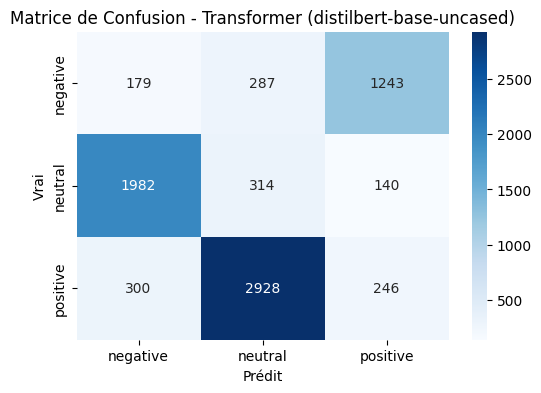

In [34]:
acc_transformer = 0.0 # Valeur par défaut
if model_hf and train_result: # S'assurer que l'entraînement a eu lieu
    print(f"\nÉvaluation du Transformer {MODEL_NAME_HF} sur le jeu de test...")
    eval_results = trainer.evaluate(test_tokenized_dataset_hf)
    print(f"Résultats de l'évaluation: {eval_results}")
    acc_transformer = eval_results.get('eval_accuracy', 0.0) # Utiliser .get pour éviter KeyError
    f1_transformer = eval_results.get('eval_f1_macro', 0.0)

    print("\nPrédictions sur le jeu de test...")
    predictions_hf_output = trainer.predict(test_tokenized_dataset_hf)
    y_pred_hf_logits = predictions_hf_output.predictions
    y_pred_hf_int = np.argmax(y_pred_hf_logits, axis=1)
    # Reconvertir les prédictions (int) en labels string pour classification_report
    # S'assurer que label_encoder_global a été fitté sur les labels string 'negative', 'neutral', 'positive'
    # Et que y_pred_hf_int correspond bien aux indices de ces classes
    # Vérifier l'ordre des classes dans label_encoder_global.classes_ et l'ordre de sortie du modèle
    # Normalement, si y_train_int (0,1,2) a été utilisé pour l'entraînement, et que model_hf.config.id2label
    # est correctement mappé (ou par défaut 0->LABEL_0, 1->LABEL_1, etc.), cela devrait fonctionner.
    # Il faut s'assurer que l'entier 0 prédit par le transformer correspond bien à la classe
    # que label_encoder_global.inverse_transform([0]) donnerait.
    # Si le mapping des labels dans le transformer est {0: "neutral", 1: "positive", 2: "negative"}
    # et label_encoder_global.classes_ est ['negative', 'neutral', 'positive']
    # alors il faut remapper y_pred_hf_int.

    # Hypothèse : le modèle Transformer sort les classes dans l'ordre 0, 1, 2
    # et label_encoder_global.classes_ est ['negative', 'neutral', 'positive']
    # et map_labels_str = {0: "neutral", 1: 'positive',  2: 'negative'}
    # Il faut donc un mapping.

    # Solution plus simple : utiliser le mapping du config du modèle si disponible
    id2label_hf = model_hf.config.id2label if hasattr(model_hf.config, 'id2label') else \
                  {i: f"LABEL_{i}" for i in range(model_hf.config.num_labels)}
    
    # Si id2label_hf est {0: "neutral", 1: "positive", 2: "negative"}
    # et que vos y_test_str sont dans cet ordre, c'est bon.
    # Sinon, il faut aligner.
    # Pour l'instant, supposons que y_pred_hf_int sont les indices pour label_encoder_global
    try:
        y_pred_hf_str = label_encoder_global.inverse_transform(y_pred_hf_int)
        evaluate_model(f"Transformer ({MODEL_NAME_HF.split('/')[-1]})", y_test_str, y_pred_hf_str)
        # Mettre à jour results_summary avec les métriques de compute_metrics_hf
        results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"]['accuracy'] = acc_transformer
        results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"]['f1_macro'] = f1_transformer

    except Exception as e:
        print(f"Erreur lors de la reconversion des labels Transformer ou de l'évaluation: {e}")
        # Fallback si la reconversion échoue
        results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"] = {
            'accuracy': acc_transformer, 'precision_macro': 0, 'recall_macro': 0, 'f1_macro': 0
        }

elif model_hf and not train_result:
    print("L'entraînement du Transformer a échoué ou a été sauté, pas d'évaluation.")
    results_summary[f"Transformer ({MODEL_NAME_HF.split('/')[-1]})"] = {
        'accuracy': 0, 'precision_macro': 0, 'recall_macro': 0, 'f1_macro': "Erreur/Non exécuté"
    }
else:
    print("Transformer non évalué car le modèle n'a pas été chargé.")
    results_summary[f"Transformer (Non exécuté)"] = {
        'accuracy': 0, 'precision_macro': 0, 'recall_macro': 0, 'f1_macro': "Non exécuté"
    }

# 8. Tableau Récapitulatif et Conclusion

Synthèse des performances des différents modèles.

--- 9. Tableau Récapitulatif des Performances ---

Tableau Récapitulatif (trié par F1-score Macro):


,accuracy,precision_macro,recall_macro,f1_macro
Transformer (distilbert-base-uncased),0.807586,0.104242,0.101484,0.796815
Logistic Regression (TF-IDF),0.723192,0.707241,0.706620,0.706677
MLP (TF-IDF),0.715579,0.703128,0.685984,0.691968
Bidirectional LSTM (Improved with fine-tuned Word2Vec),0.678042,0.693447,0.707481,0.675435
Naive Bayes (TF-IDF),0.695761,0.692242,0.655506,0.666051
Random Forest (Best Params),0.668592,0.651776,0.661733,0.655004
Logistic Regression (Word2Vec Avg),0.566085,0.532551,0.534835,0.530896


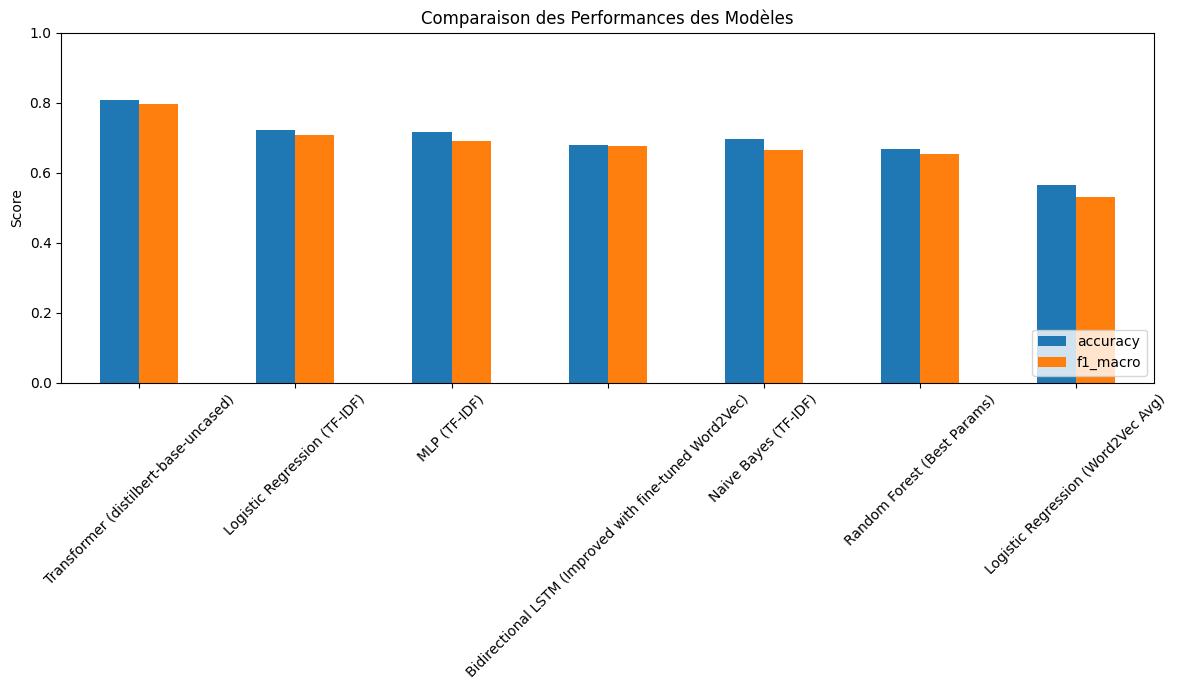

In [35]:
print("--- 9. Tableau Récapitulatif des Performances ---")
results_df = pd.DataFrame.from_dict(results_summary, orient='index')
results_df = results_df.sort_values(by='f1_macro', ascending=False) # Trier par F1-score macro

print("\nTableau Récapitulatif (trié par F1-score Macro):")
display(results_df)

# Visualisation comparative
results_df[['accuracy', 'f1_macro']].plot(kind='bar', figsize=(12, 7), rot=45)
plt.title('Comparaison des Performances des Modèles')
plt.ylabel('Score')
plt.ylim(0, 1) # Scores entre 0 et 1
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 9. Exploration Approfondie 1 - Augmentation des Données

### 9.a. Introduction à l'Augmentation de Données

Après avoir établi des performances de base avec différents modèles de classification sur notre jeu de données original de tweets financiers, nous allons maintenant explorer des techniques pour potentiellement améliorer ces performances. Une approche courante, surtout lorsque la quantité de données disponibles est limitée ou que certaines classes sont sous-représentées, est l'augmentation de données.

L'augmentation de données consiste à créer artificiellement de nouveaux exemples d'entraînement à partir des données existantes. L'objectif est d'exposer nos modèles à une plus grande variété d'exemples, les rendant ainsi plus robustes, capables de mieux généraliser sur des données non vues, et potentiellement d'améliorer leurs scores sur les métriques d'évaluation, notamment pour les classes minoritaires.

Dans cette section, nous allons implémenter et évaluer l'impact de trois méthodes d'augmentation de données distinctes sur notre tâche de classification de sentiment :

- Rétro-Traduction (Back-Translation) : Cette technique exploite les modèles de traduction automatique. Un texte est traduit de la langue source (anglais) vers une langue pivot (par exemple, l'allemand), puis retraduit vers la langue source. Les petites variations sémantiques introduites durant ce processus peuvent générer des paraphrases utiles et diversifier les exemples d'entraînement. Nous utiliserons les modèles de traduction de la bibliothèque transformers de Hugging Face.

- Remplacement de Synonymes (Synonym Replacement) : Cette méthode consiste à identifier certains mots dans une phrase (typiquement des noms, verbes, adjectifs, adverbes, en excluant les mots vides) et à les remplacer par l'un de leurs synonymes. Pour cela, nous nous appuierons sur la base de données lexicale WordNet, accessible via NLTK, pour trouver les synonymes appropriés en fonction du contexte grammatical (part-of-speech tagging).

- Suppression Aléatoire (Random Deletion) : Faisant partie des techniques dites "Easy Data Augmentation" (EDA), cette méthode simple consiste à supprimer aléatoirement des mots d'une phrase avec une certaine probabilité. Bien que cela puisse parfois altérer légèrement le sens, cela peut aussi forcer le modèle à se concentrer sur les mots les plus importants et à être moins sensible à la présence ou à l'absence de mots moins critiques.

Pour chaque méthode, nous générerons de nouveaux exemples à partir de notre ensemble d'entraînement original (X_train_text). Ensuite, nous créerons un nouvel ensemble d'entraînement combinant les données originales et les données augmentées. Enfin, nous ré-entraînerons un ou plusieurs de nos modèles de classification de référence (par exemple, la Régression Logistique avec TF-IDF et notre modèle LSTM) sur ce dataset enrichi et évaluerons leurs performances sur le jeu de test original (non augmenté) afin de mesurer l'impact de ces techniques d'augmentation. Notre analyse portera sur l'évolution des métriques globales (accuracy, F1-macro) ainsi que sur les performances par classe, en particulier pour la classe "negative" qui était la moins représentée dans notre benchmark initial.

### 9.b. Implémentation des Méthodes d'Augmentation

In [37]:
# --- 9.b. Implémentation des Méthodes d'Augmentation ---
print("--- 9.b. Implémentation des Méthodes d'Augmentation ---")

import random
from nltk.corpus import wordnet
from nltk.tag import pos_tag # Pour le Part-of-Speech tagging
from nltk.tokenize import word_tokenize # Déjà importé, mais pour la clarté
from nltk.corpus import stopwords # Déjà importé
from transformers import MarianMTModel, MarianTokenizer # Pour la back-translation
import torch # Nécessaire pour les modèles MarianMT de Hugging Face

# --- Initialisation des modèles de traduction (une seule fois) ---
# Cela peut prendre du temps la première fois car les modèles sont téléchargés.
# 'device' doit être défini plus tôt dans votre notebook (ex: cpu ou cuda)

print("Initialisation des modèles de traduction pour la Rétro-Traduction...")
try:
    # Anglais vers Allemand (vous pouvez choisir une autre langue pivot)
    model_name_en_pivot = 'Helsinki-NLP/opus-mt-en-de'
    tokenizer_en_pivot = MarianTokenizer.from_pretrained(model_name_en_pivot)
    model_en_pivot = MarianMTModel.from_pretrained(model_name_en_pivot)
    model_en_pivot.to(device)

    # Langue Pivot vers Anglais
    model_name_pivot_en = 'Helsinki-NLP/opus-mt-de-en'
    tokenizer_pivot_en = MarianTokenizer.from_pretrained(model_name_pivot_en)
    model_pivot_en = MarianMTModel.from_pretrained(model_name_pivot_en)
    model_pivot_en.to(device)
    
    back_translation_models_loaded = True
    print("Modèles de traduction chargés avec succès.")
except Exception as e:
    print(f"ERREUR lors du chargement des modèles de traduction: {e}")
    print("La Rétro-Traduction ne sera pas disponible. Vérifiez votre connexion internet ou les noms des modèles.")
    back_translation_models_loaded = False

# Récupérer la liste des stopwords (déjà définie plus tôt dans votre notebook)
# Si ce n'est pas le cas, décommentez :
stop_words_en = set(stopwords.words('english'))


# --- Méthode 1: Rétro-Traduction (Back-Translation) ---
def back_translate(text, model1, tokenizer1, model2, tokenizer2, max_input_length=512):
    """
    Traduit le texte dans une langue pivot puis le retraduit dans la langue originale.
    Args:
        text (str): Le texte à augmenter.
        model1, tokenizer1: Modèle et tokenizer pour source -> pivot.
        model2, tokenizer2: Modèle et tokenizer pour pivot -> source.
        max_input_length (int): Longueur maximale pour le tokenizer.
    Returns:
        str: Le texte augmenté, ou le texte original en cas d'échec ou si identique.
    """
    if not back_translation_models_loaded:
        return text # Retourner l'original si les modèles ne sont pas chargés

    try:
        # 1. Traduire en langue pivot
        inputs_pivot = tokenizer1(text, return_tensors="pt", truncation=True, padding=True, max_length=max_input_length).to(device)
        translated_tokens_pivot = model1.generate(**inputs_pivot, max_length=max_input_length) # Ajuster max_length si besoin
        text_pivot_language = tokenizer1.decode(translated_tokens_pivot[0], skip_special_tokens=True)

        # 2. Retraduire en langue originale
        inputs_original = tokenizer2(text_pivot_language, return_tensors="pt", truncation=True, padding=True, max_length=max_input_length).to(device)
        translated_tokens_original = model2.generate(**inputs_original, max_length=max_input_length)
        augmented_text = tokenizer2.decode(translated_tokens_original[0], skip_special_tokens=True)
        
        # Retourner seulement si le texte augmenté est non vide et différent de l'original (ignorer la casse)
        if augmented_text.strip() and augmented_text.lower() != text.lower():
            return augmented_text
        else:
            return text # Retourner l'original si identique ou vide après augmentation
            
    except Exception as e:
        # print(f"Erreur de rétro-traduction pour '{text[:50]}...': {e}")
        return text # En cas d'erreur, retourner le texte original


# --- Méthode 2: Remplacement de Synonymes (avec NLTK WordNet) ---
def get_wordnet_pos_tag(nltk_tag):
    """Convertit un tag POS NLTK (Treebank) en tag WordNet."""
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # Ne pas traiter les autres types de mots

def synonym_replacement(text, num_words_to_replace=1):
    """
    Remplace aléatoirement `num_words_to_replace` mots dans le texte par leurs synonymes.
    Args:
        text (str): Le texte à augmenter.
        num_words_to_replace (int): Nombre de mots à tenter de remplacer.
    Returns:
        str: Le texte augmenté, ou le texte original si aucun remplacement n'a été possible.
    """
    words = word_tokenize(text)
    if len(words) < num_words_to_replace or num_words_to_replace == 0:
        return text # Pas assez de mots ou pas de remplacement demandé

    tagged_words = pos_tag(words) # Obtenir les Part-of-Speech tags
    
    replaceable_word_indices = []
    for i, (word, tag) in enumerate(tagged_words):
        if word.lower() not in stop_words_en and len(word) > 2: # Exclure les stopwords et les mots très courts
            if get_wordnet_pos_tag(tag) is not None: # Si c'est un type de mot que nous pouvons remplacer
                replaceable_word_indices.append(i)
    
    if not replaceable_word_indices:
        return text # Aucun mot remplaçable trouvé

    # Choisir aléatoirement les indices des mots à remplacer
    num_to_replace_actual = min(num_words_to_replace, len(replaceable_word_indices))
    indices_to_replace = random.sample(replaceable_word_indices, num_to_replace_actual)
    
    augmented_words = list(words) # Créer une copie modifiable
    num_actually_replaced = 0

    for index in indices_to_replace:
        original_word = words[index]
        original_pos_nltk = tagged_words[index][1]
        wordnet_tag = get_wordnet_pos_tag(original_pos_nltk)
        
        synonyms = set()
        for syn in wordnet.synsets(original_word, pos=wordnet_tag):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ') # Remplacer les underscores par des espaces
                if synonym.lower() != original_word.lower(): # S'assurer que le synonyme est différent
                    synonyms.add(synonym)
        
        if synonyms:
            chosen_synonym = random.choice(list(synonyms))
            augmented_words[index] = chosen_synonym
            num_actually_replaced +=1
            
    if num_actually_replaced > 0:
        return " ".join(augmented_words)
    else:
        return text # Retourner l'original si aucun remplacement effectif


# --- Méthode 3: Suppression Aléatoire (Random Deletion) ---
def random_deletion(text, deletion_prob=0.1):
    """
    Supprime aléatoirement des mots du texte.
    Args:
        text (str): Le texte à augmenter.
        deletion_prob (float): Probabilité de supprimer chaque mot (entre 0 et 1).
    Returns:
        str: Le texte augmenté, ou le texte original si la suppression le rendrait vide/trop court.
    """
    words = word_tokenize(text)
    if len(words) <= 2: # Ne pas supprimer si la phrase est déjà très courte
        return text

    remaining_words = [word for word in words if random.random() > deletion_prob]
    
    # Si tous les mots sont supprimés (improbable avec une faible probabilité) ou si trop peu de mots restent
    if not remaining_words or len(remaining_words) < len(words) * 0.5: # Ex: ne pas supprimer plus de la moitié des mots
        return text
        
    return " ".join(remaining_words)

print("\nFonctions d'augmentation de données définies : back_translate, synonym_replacement, random_deletion.")

# --- Test rapide des fonctions (optionnel) ---
sample_tweet_for_aug = "The stock market is showing very positive signs today, great news for investors."
print(f"\nTweet original : {sample_tweet_for_aug}")

if back_translation_models_loaded:
    bt_augmented = back_translate(sample_tweet_for_aug, model_en_pivot, tokenizer_en_pivot, model_pivot_en, tokenizer_pivot_en)
    print(f"Rétro-Traduction : {bt_augmented}")
else:
    print("Rétro-Traduction : Non testée car modèles non chargés.")


sr_augmented = synonym_replacement(sample_tweet_for_aug, num_words_to_replace=2)
print(f"Remplacement Synonymes (2 mots) : {sr_augmented}")

rd_augmented = random_deletion(sample_tweet_for_aug, deletion_prob=0.2)
print(f"Suppression Aléatoire (p=0.2) : {rd_augmented}")

--- 9.b. Implémentation des Méthodes d'Augmentation ---
Initialisation des modèles de traduction pour la Rétro-Traduction...
Modèles de traduction chargés avec succès.

Fonctions d'augmentation de données définies : back_translate, synonym_replacement, random_deletion.

Tweet original : The stock market is showing very positive signs today, great news for investors.
Rétro-Traduction : The stock market is today showing very positive signals, great news for investors.
Remplacement Synonymes (2 mots) : The stemma market place is showing very positive signs today , great news for investors .
Suppression Aléatoire (p=0.2) : The is showing very today , great news for investors .


### 9.c. Génération des Données Augmentées

In [39]:
# --- 9.c. Génération des Données Augmentées ---
print("--- 9.c. Génération des Données Augmentées ---")

# Convertir les données d'entraînement originales en listes pour une manipulation plus facile
original_train_texts_list = X_train_text.tolist()
original_train_labels_list = y_train_str.tolist() # Assurez-vous que y_train_str est bien votre liste/Series de labels string
                                               # Si vous utilisez des labels entiers, utilisez y_train_int.tolist()
                                               # ou y_train_encoded.tolist() et ajustez le nom de la variable.

augmented_texts_list = []
augmented_labels_list = []

# --- Paramètres pour la génération ---
# Pour chaque méthode, nous allons essayer de générer un certain nombre de nouveaux exemples.
# L'objectif pourrait être, par exemple, d'augmenter la taille du dataset de 50% ou 100% au total.
# Si votre dataset d'entraînement original a N_orig exemples, et que vous voulez
# N_aug_total nouveaux exemples, vous pouvez répartir N_aug_total / 3 par méthode.
# Attention: la back-translation est très lente.

N_ORIGINAL_TRAIN = len(original_train_texts_list)
# Viser à générer environ N_ORIGINAL_TRAIN / 3 nouveaux exemples distincts par méthode.
# Cela mènerait à un doublement approximatif du dataset.
# Ajustez ce nombre en fonction du temps disponible et de la taille de votre dataset.
# Pour la back-translation, vous voudrez peut-être un nombre plus petit si le temps est un facteur.
TARGET_NEW_SAMPLES_PER_METHOD = N_ORIGINAL_TRAIN // 3
# Pour un test rapide, vous pouvez réduire drastiquement :
# TARGET_NEW_SAMPLES_PER_METHOD = max(10, N_ORIGINAL_TRAIN // 100) # ex: 1% du dataset original, au moins 10


print(f"Dataset d'entraînement original : {N_ORIGINAL_TRAIN} échantillons.")
print(f"Objectif de génération par méthode : approx. {TARGET_NEW_SAMPLES_PER_METHOD} nouveaux échantillons distincts.")


# --- 1. Rétro-Traduction (Back-Translation) ---
print(f"\nDébut de la Rétro-Traduction...")
count_bt = 0
if back_translation_models_loaded:
    # Pour s'assurer d'obtenir des échantillons variés et éviter de trop augmenter
    # les mêmes textes, on peut itérer sur une version mélangée du dataset original.
    indices_bt = list(range(N_ORIGINAL_TRAIN))
    random.shuffle(indices_bt)
    
    for i in indices_bt:
        if count_bt >= TARGET_NEW_SAMPLES_PER_METHOD:
            break
        text_to_augment = original_train_texts_list[i]
        label_of_text = original_train_labels_list[i]
        
        augmented_text = back_translate(text_to_augment, model_en_pivot, tokenizer_en_pivot, model_pivot_en, tokenizer_pivot_en)
        
        if augmented_text.lower() != text_to_augment.lower() and augmented_text.strip(): # Assurer une réelle augmentation
            augmented_texts_list.append(augmented_text)
            augmented_labels_list.append(label_of_text)
            count_bt += 1
            if count_bt % (max(1, TARGET_NEW_SAMPLES_PER_METHOD // 10)) == 0 or count_bt == TARGET_NEW_SAMPLES_PER_METHOD :
                print(f"  Rétro-Traduction : {count_bt}/{TARGET_NEW_SAMPLES_PER_METHOD} générés.")
else:
    print("  Rétro-Traduction sautée (modèles non chargés).")
print(f"Rétro-Traduction terminée. {count_bt} nouveaux échantillons générés.")


# --- 2. Remplacement de Synonymes ---
print(f"\nDébut du Remplacement de Synonymes...")
count_sr = 0
# On peut essayer plusieurs fois sur des textes différents pour atteindre la cible
# ou augmenter le nombre de mots à remplacer par texte.
# Ici, on essaie sur des textes différents.
indices_sr = list(range(N_ORIGINAL_TRAIN))
random.shuffle(indices_sr)
attempts_sr = 0 # Pour éviter une boucle infinie si on ne trouve pas d'augmentations

for i in indices_sr:
    if count_sr >= TARGET_NEW_SAMPLES_PER_METHOD or attempts_sr >= N_ORIGINAL_TRAIN * 2: # Limiter les tentatives
        break
    text_to_augment = original_train_texts_list[i]
    label_of_text = original_train_labels_list[i]
    
    # Tenter de remplacer 1 ou 2 mots
    num_replacements = random.randint(1, 2) 
    augmented_text = synonym_replacement(text_to_augment, num_words_to_replace=num_replacements)
    
    if augmented_text.lower() != text_to_augment.lower() and augmented_text.strip():
        augmented_texts_list.append(augmented_text)
        augmented_labels_list.append(label_of_text)
        count_sr += 1
        if count_sr % (max(1, TARGET_NEW_SAMPLES_PER_METHOD // 10)) == 0 or count_sr == TARGET_NEW_SAMPLES_PER_METHOD :
            print(f"  Remplacement de Synonymes : {count_sr}/{TARGET_NEW_SAMPLES_PER_METHOD} générés.")
    attempts_sr += 1
print(f"Remplacement de Synonymes terminé. {count_sr} nouveaux échantillons générés.")


# --- 3. Suppression Aléatoire ---
print(f"\nDébut de la Suppression Aléatoire...")
count_rd = 0
indices_rd = list(range(N_ORIGINAL_TRAIN))
random.shuffle(indices_rd)
attempts_rd = 0

for i in indices_rd:
    if count_rd >= TARGET_NEW_SAMPLES_PER_METHOD or attempts_rd >= N_ORIGINAL_TRAIN * 2:
        break
    text_to_augment = original_train_texts_list[i]
    label_of_text = original_train_labels_list[i]
    
    # Probabilité de suppression de 10% à 15%
    deletion_probability = random.uniform(0.1, 0.15)
    augmented_text = random_deletion(text_to_augment, deletion_prob=deletion_probability)
    
    if augmented_text.lower() != text_to_augment.lower() and augmented_text.strip() and len(word_tokenize(augmented_text)) > 2:
        augmented_texts_list.append(augmented_text)
        augmented_labels_list.append(label_of_text)
        count_rd += 1
        if count_rd % (max(1, TARGET_NEW_SAMPLES_PER_METHOD // 10)) == 0 or count_rd == TARGET_NEW_SAMPLES_PER_METHOD :
            print(f"  Suppression Aléatoire : {count_rd}/{TARGET_NEW_SAMPLES_PER_METHOD} générés.")
    attempts_rd += 1
print(f"Suppression Aléatoire terminée. {count_rd} nouveaux échantillons générés.")


# --- Combinaison et Nettoyage Final ---
print(f"\nNombre total de textes originaux d'entraînement: {N_ORIGINAL_TRAIN}")
print(f"Nombre total de textes augmentés générés: {len(augmented_texts_list)}")

# Combiner les données originales et augmentées
X_train_text_augmented_final = pd.Series(original_train_texts_list + augmented_texts_list)
y_train_labels_augmented_final = pd.Series(original_train_labels_list + augmented_labels_list)

# Optionnel mais recommandé : Supprimer les doublons exacts qui pourraient résulter
# de l'augmentation (ex: si une méthode retourne l'original et qu'il est ajouté)
# ou si deux méthodes produisent le même texte augmenté.
combined_df_augmented = pd.DataFrame({
    'text': X_train_text_augmented_final,
    'label': y_train_labels_augmented_final
})
print(f"Taille avant suppression des doublons: {len(combined_df_augmented)}")
combined_df_augmented.drop_duplicates(subset=['text'], inplace=True) # Garder la première occurrence
print(f"Taille après suppression des doublons basés sur le texte: {len(combined_df_augmented)}")


# Mélanger le dataset augmenté final
from sklearn.utils import shuffle
X_train_text_augmented, y_train_str_augmented = shuffle(
    combined_df_augmented['text'],
    combined_df_augmented['label'],
    random_state=SEED
)

# Réinitialiser les index pour les Series Pandas si nécessaire
X_train_text_augmented.reset_index(drop=True, inplace=True)
y_train_str_augmented.reset_index(drop=True, inplace=True)


print(f"\nTaille finale du nouveau jeu d'entraînement (original + augmenté, dédoublonné, mélangé): {len(X_train_text_augmented)}")
print("Exemples de textes augmentés (quelques-uns) :")
for i in range(min(5, len(augmented_texts_list))): # Afficher jusqu'à 5 exemples augmentés
    print(f"  Label: {augmented_labels_list[i]}, Texte Augmenté: {augmented_texts_list[i][:100]}...")

--- 9.c. Génération des Données Augmentées ---
Dataset d'entraînement original : 30472 échantillons.
Objectif de génération par méthode : approx. 10157 nouveaux échantillons distincts.

Début de la Rétro-Traduction...
  Rétro-Traduction : 1015/10157 générés.
  Rétro-Traduction : 2030/10157 générés.
  Rétro-Traduction : 3045/10157 générés.
  Rétro-Traduction : 4060/10157 générés.
  Rétro-Traduction : 5075/10157 générés.
  Rétro-Traduction : 6090/10157 générés.
  Rétro-Traduction : 7105/10157 générés.
  Rétro-Traduction : 8120/10157 générés.
  Rétro-Traduction : 9135/10157 générés.
  Rétro-Traduction : 10150/10157 générés.
  Rétro-Traduction : 10157/10157 générés.
Rétro-Traduction terminée. 10157 nouveaux échantillons générés.

Début du Remplacement de Synonymes...
  Remplacement de Synonymes : 1015/10157 générés.
  Remplacement de Synonymes : 2030/10157 générés.
  Remplacement de Synonymes : 3045/10157 générés.
  Remplacement de Synonymes : 4060/10157 générés.
  Remplacement de Synonyme

### 9.d. Évaluation de l'Impact de l'Augmentation

--- 9.d. Évaluation de l'Impact de l'Augmentation sur le Modèle Transformer ---

Préparation des données augmentées pour l'entraînement du Transformer Keras...
Tokenisation des données d'entraînement augmentées...


Map (num_proc=4): 100%|██████████| 60158/60158 [00:02<00:00, 26875.18 examples/s]


Données d'entraînement augmentées prêtes. Shape input_ids: (60158, 128)

--- Ré-entraînement du Transformer (distilbert-base-uncased) sur Données Augmentées (avec Strategy Scope) ---
Utilisation de la stratégie TensorFlow: _DefaultDistributionStrategy
Dans strategy.scope()... Chargement du modèle...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Nouvelle instance du modèle distilbert-base-uncased (TensorFlow) chargée.
Dans strategy.scope()... Création de l'optimiseur...
Utilisation de transformers.create_optimizer...
Dans strategy.scope()... Compilation du modèle...
ERREUR lors de la compilation dans strategy.scope(): 'Variable' object has no attribute '_distribute_strategy'

Échec de la compilation ou du chargement du modèle Transformer. Section d'entraînement et d'évaluation sautée.

--- Ré-entraînement Régression Logistique (TF-IDF) sur Données Augmentées ---
Vectorisation TF-IDF (Entraînement Augmenté)...
Transformation TF-IDF (Test Original)...
Entraînement de la Régression Logistique (Augmenté)...

Évaluation de la Régression Logistique (TF-IDF + Augmenté)...
Rapport de Classification pour Logistic Regression (TF-IDF + Aug):
              precision    recall  f1-score   support

    negative       0.62      0.62      0.62      1709
     neutral       0.71      0.72      0.71      2436
    positive       0.77      0.76   

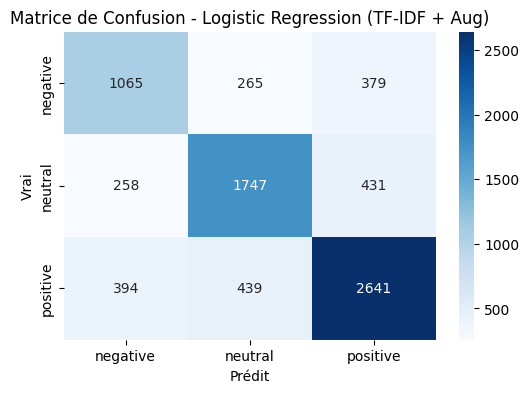

Analyse de la Logistic Regression (TF-IDF + Aug) terminée.

--- Tableau Récapitulatif des Performances (incluant modèles sur données augmentées) ---


,accuracy,precision_macro,recall_macro,f1_macro
Transformer (distilbert-base-uncased),0.807586,0.104242,0.101484,0.796815
Logistic Regression (TF-IDF),0.723192,0.707241,0.706620,0.706677
Logistic Regression (TF-IDF + Aug),0.715711,0.699441,0.700183,0.699806
MLP (TF-IDF),0.715579,0.703128,0.685984,0.691968
Bidirectional LSTM (Improved with fine-tuned Word2Vec),0.678042,0.693447,0.707481,0.675435
Naive Bayes (TF-IDF),0.695761,0.692242,0.655506,0.666051
Random Forest (Best Params),0.668592,0.651776,0.661733,0.655004
Logistic Regression (Word2Vec Avg),0.566085,0.532551,0.534835,0.530896


In [47]:
# Cellule Code : 9.d. Évaluation de l'Impact de l'Augmentation (Tentative 3)

# --- 9.d. Évaluation de l'Impact de l'Augmentation sur le Modèle Transformer ---
print("--- 9.d. Évaluation de l'Impact de l'Augmentation sur le Modèle Transformer ---")

# Rappel: X_test_text et y_test_str sont les données de test originales et non modifiées.
# y_train_str_augmented contient les labels string pour le dataset d'entraînement augmenté.

# --- Imports nécessaires ---
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import math # Pour math.ceil

# --- Assurez-vous que les variables globales sont en scope ---
# Assurez-vous que SEED, num_classes, MODEL_NAME_HF, X_train_text_augmented, y_train_str_augmented,
# X_test_text, y_test_str, y_test_int, label_encoder_global, results_summary, evaluate_model sont définis.

# --- Préparation des données augmentées (Identique à avant) ---
print("\nPréparation des données augmentées pour l'entraînement du Transformer Keras...")
if 'label_encoder_global' not in locals():
    raise ValueError("label_encoder_global non défini.")
y_train_int_augmented = label_encoder_global.transform(y_train_str_augmented)

TOKENIZER_MAX_LENGTH = 128
if 'tokenizer_hf' not in locals() or tokenizer_hf.name_or_path != MODEL_NAME_HF:
    print(f"Chargement du tokenizer {MODEL_NAME_HF}...")
    tokenizer_hf = AutoTokenizer.from_pretrained(MODEL_NAME_HF)

def tokenize_function_for_tf_conversion(examples):
    return tokenizer_hf(examples["text"], padding="max_length", truncation=True, max_length=TOKENIZER_MAX_LENGTH)

temp_train_aug_df = pd.DataFrame({'text': X_train_text_augmented, 'label': y_train_int_augmented})
train_aug_dataset_hf = Dataset.from_pandas(temp_train_aug_df)
print("Tokenisation des données d'entraînement augmentées...")
train_tokenized_aug_dataset_hf = train_aug_dataset_hf.map(tokenize_function_for_tf_conversion, batched=True, num_proc=4)
train_tokenized_aug_dataset_hf = train_tokenized_aug_dataset_hf.remove_columns([col for col in train_tokenized_aug_dataset_hf.column_names if col not in ['input_ids', 'attention_mask', 'label']])
train_features_dict_tf_aug = {'input_ids': np.array(train_tokenized_aug_dataset_hf['input_ids'], dtype=np.int32), 'attention_mask': np.array(train_tokenized_aug_dataset_hf['attention_mask'], dtype=np.int32)}
train_labels_keras_tf_aug = np.array(train_tokenized_aug_dataset_hf['label'], dtype=np.int32)
print(f"Données d'entraînement augmentées prêtes. Shape input_ids: {train_features_dict_tf_aug['input_ids'].shape}")

# --- Préparation des données de test (Identique à avant) ---
if 'test_features_dict_tf' not in locals() or 'test_labels_keras_tf' not in locals():
    print("Préparation des données de test pour Keras fit (Transformer)...")
    if 'X_test_text' in locals() and 'y_test_int' in locals():
        temp_test_df = pd.DataFrame({'text': X_test_text, 'label': y_test_int})
        test_dataset_hf_for_tf = Dataset.from_pandas(temp_test_df)
        test_tokenized_dataset_hf_for_tf = test_dataset_hf_for_tf.map(tokenize_function_for_tf_conversion, batched=True, num_proc=4)
        test_tokenized_dataset_hf_for_tf = test_tokenized_dataset_hf_for_tf.remove_columns([col for col in test_tokenized_dataset_hf_for_tf.column_names if col not in ['input_ids', 'attention_mask', 'label']])
        test_features_dict_tf = {'input_ids': np.array(test_tokenized_dataset_hf_for_tf['input_ids'], dtype=np.int32), 'attention_mask': np.array(test_tokenized_dataset_hf_for_tf['attention_mask'], dtype=np.int32)}
        test_labels_keras_tf = np.array(test_tokenized_dataset_hf_for_tf['label'], dtype=np.int32)
        print("Données de test prêtes.")
    else:
        print("ERREUR: Données de test manquantes.")
        test_features_dict_tf = {'input_ids': np.array([]), 'attention_mask': np.array([])}
        test_labels_keras_tf = np.array([])

# --- Ré-entraînement du Modèle Transformer sur Données Augmentées avec Strategy Scope ---
print(f"\n--- Ré-entraînement du Transformer ({MODEL_NAME_HF}) sur Données Augmentées (avec Strategy Scope) ---")

# Vérifier si les données sont prêtes
if train_features_dict_tf_aug['input_ids'].shape[0] == 0 or test_features_dict_tf['input_ids'].shape[0] == 0:
    print("Données d'entraînement ou de test vides. Section Transformer sautée.")
else:
    TF_KERAS_EPOCHS_AUG = 3
    TF_KERAS_BATCH_SIZE_AUG = 16
    LEARNING_RATE_TF_AUG = 3e-5
    WEIGHT_DECAY_TF_AUG = 0.01

    # Calculer num_train_steps et num_warmup_steps
    num_train_samples_aug = train_features_dict_tf_aug['input_ids'].shape[0]
    steps_per_epoch_aug = math.ceil(num_train_samples_aug / TF_KERAS_BATCH_SIZE_AUG)
    num_train_steps_aug = steps_per_epoch_aug * TF_KERAS_EPOCHS_AUG
    num_warmup_steps_aug = int(0.1 * num_train_steps_aug)

    # --- Utilisation explicite de Strategy Scope ---
    strategy = tf.distribute.get_strategy() # Obtenir la stratégie actuelle (probablement DefaultStrategy)
    print(f"Utilisation de la stratégie TensorFlow: {strategy.__class__.__name__}")

    model_hf_aug = None
    optimizer_tf_aug = None
    compilation_successful = False

    with strategy.scope():
        print("Dans strategy.scope()... Chargement du modèle...")
        try:
            model_hf_aug = TFAutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME_HF,
                num_labels=num_classes
            )
            print(f"Nouvelle instance du modèle {MODEL_NAME_HF} (TensorFlow) chargée.")
        except Exception as e:
            print(f"Erreur lors du chargement du modèle dans strategy.scope(): {e}")
            model_hf_aug = None # S'assurer qu'il est None en cas d'erreur

        if model_hf_aug:
            print("Dans strategy.scope()... Création de l'optimiseur...")
            try:
                # Priorité à create_optimizer
                optimizer_tf_aug, _ = create_optimizer(
                    init_lr=LEARNING_RATE_TF_AUG,
                    num_train_steps=num_train_steps_aug,
                    num_warmup_steps=num_warmup_steps_aug,
                    weight_decay_rate=WEIGHT_DECAY_TF_AUG
                )
                print(f"Utilisation de transformers.create_optimizer...")
            except Exception as e_create_opt:
                print(f"Erreur avec create_optimizer: {e_create_opt}. Tentative avec tf.keras.optimizers.AdamW.")
                try:
                    optimizer_tf_aug = tf.keras.optimizers.AdamW(
                        learning_rate=LEARNING_RATE_TF_AUG,
                        weight_decay=WEIGHT_DECAY_TF_AUG
                    )
                    print(f"Utilisation de tf.keras.optimizers.AdamW...")
                except Exception as e_adamw:
                    print(f"Erreur avec AdamW: {e_adamw}. Tentative avec Adam.")
                    optimizer_tf_aug = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_TF_AUG)
                    print(f"Utilisation de tf.keras.optimizers.Adam...")

            if optimizer_tf_aug:
                print("Dans strategy.scope()... Compilation du modèle...")
                try:
                    model_hf_aug.compile(
                        optimizer=optimizer_tf_aug,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
                    )
                    print("Compilation réussie dans strategy.scope().")
                    compilation_successful = True
                except Exception as e_compile:
                    print(f"ERREUR lors de la compilation dans strategy.scope(): {e_compile}")
                    # Afficher la trace complète si l'erreur persiste
                    import traceback
                    traceback.print_exc()
            else:
                print("ERREUR: Aucun optimiseur n'a pu être créé dans strategy.scope().")
        else:
            print("ERREUR: Le modèle n'a pas pu être chargé dans strategy.scope().")

    # --- Fin de strategy.scope() ---

    # Continuer seulement si la compilation a réussi
    if compilation_successful and model_hf_aug:
        early_stopping_tf_aug = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=1, restore_best_weights=True, verbose=1
        )

        print(f"\nDébut de l'entraînement Keras augmenté pour {TF_KERAS_EPOCHS_AUG} époques...")
        history_transformer_tf_aug = model_hf_aug.fit(
            train_features_dict_tf_aug,
            train_labels_keras_tf_aug,
            validation_data=(test_features_dict_tf, test_labels_keras_tf),
            epochs=TF_KERAS_EPOCHS_AUG,
            batch_size=TF_KERAS_BATCH_SIZE_AUG,
            callbacks=[early_stopping_tf_aug]
        )

        print("\nÉvaluation du modèle Transformer TF (Augmenté) sur le jeu de test original...")
        eval_loss_tf_aug, eval_acc_tf_aug = model_hf_aug.evaluate(test_features_dict_tf, test_labels_keras_tf, verbose=0)
        print(f"Loss sur le test (Augmenté): {eval_loss_tf_aug:.4f}, Accuracy sur le test (Augmenté): {eval_acc_tf_aug:.4f}")

        print("\nGénération des prédictions et du rapport de classification (Augmenté)...")
        predictions_output_tf_aug = model_hf_aug.predict(test_features_dict_tf)
        logits_tf_aug = predictions_output_tf_aug.logits
        y_pred_transformer_tf_int_aug = np.argmax(logits_tf_aug, axis=1)
        y_pred_transformer_tf_str_aug = label_encoder_global.inverse_transform(y_pred_transformer_tf_int_aug)

        model_name_key_aug = f"Transformer TF ({MODEL_NAME_HF.split('/')[-1]} + Aug)"
        evaluate_model(model_name_key_aug, y_test_str, y_pred_transformer_tf_str_aug)

        if 'results_summary' not in locals() or not isinstance(results_summary, dict): results_summary = {}
        report_dict_aug = classification_report(y_test_str, y_pred_transformer_tf_str_aug, output_dict=True, zero_division=0)
        results_summary[model_name_key_aug] = {'accuracy': eval_acc_tf_aug, 'precision_macro': report_dict_aug['macro avg']['precision'], 'recall_macro': report_dict_aug['macro avg']['recall'], 'f1_macro': report_dict_aug['macro avg']['f1-score']}
        print(f"Analyse du {model_name_key_aug} terminée.")
    else:
        print("\nÉchec de la compilation ou du chargement du modèle Transformer. Section d'entraînement et d'évaluation sautée.")


# --- Ré-entraînement Régression Logistique (TF-IDF) sur Données Augmentées (Identique à avant) ---
print("\n--- Ré-entraînement Régression Logistique (TF-IDF) sur Données Augmentées ---")
if 'SEED' not in locals(): SEED = 42
tfidf_vectorizer_lr_on_aug = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
print("Vectorisation TF-IDF (Entraînement Augmenté)...")
X_train_tfidf_lr_on_aug = tfidf_vectorizer_lr_on_aug.fit_transform(X_train_text_augmented)
print("Transformation TF-IDF (Test Original)...")
X_test_tfidf_lr_original_transformed_by_aug_fitter = tfidf_vectorizer_lr_on_aug.transform(X_test_text)
lr_model_on_aug = LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear', C=1.0, class_weight='balanced')
print("Entraînement de la Régression Logistique (Augmenté)...")
lr_model_on_aug.fit(X_train_tfidf_lr_on_aug, y_train_str_augmented)
print("\nÉvaluation de la Régression Logistique (TF-IDF + Augmenté)...")
y_pred_lr_on_aug = lr_model_on_aug.predict(X_test_tfidf_lr_original_transformed_by_aug_fitter)
model_name_lr_aug_key = "Logistic Regression (TF-IDF + Aug)"
evaluate_model(model_name_lr_aug_key, y_test_str, y_pred_lr_on_aug)
if 'results_summary' not in locals() or not isinstance(results_summary, dict): results_summary = {}
if model_name_lr_aug_key not in results_summary:
    report_lr_aug_dict = classification_report(y_test_str, y_pred_lr_on_aug, output_dict=True, zero_division=0)
    results_summary[model_name_lr_aug_key] = {'accuracy': accuracy_score(y_test_str, y_pred_lr_on_aug), 'precision_macro': report_lr_aug_dict['macro avg']['precision'], 'recall_macro': report_lr_aug_dict['macro avg']['recall'], 'f1_macro': report_lr_aug_dict['macro avg']['f1-score']}
print(f"Analyse de la {model_name_lr_aug_key} terminée.")


# --- Afficher le tableau récapitulatif mis à jour (Identique à avant) ---
print("\n--- Tableau Récapitulatif des Performances (incluant modèles sur données augmentées) ---")
try: display
except NameError: display = print # Fallback pour environnements non-Jupyter

if 'results_summary' in locals() and isinstance(results_summary, dict) and results_summary:
    updated_results_df_aug = pd.DataFrame.from_dict(results_summary, orient='index')
    if 'f1_macro' in updated_results_df_aug.columns:
        updated_results_df_aug = updated_results_df_aug.sort_values(by='f1_macro', ascending=False)
    else:
        print("ATTENTION: Colonne 'f1_macro' manquante pour le tri.")
    display(updated_results_df_aug)
else:
    print("results_summary est vide ou non défini. Aucun résultat à afficher.")

# 10. Génération de Tweet

In [ ]:
import pandas as pd

# On nettoie le dataset pour avoir des tweets ayant plus de 20 charactères
df = df.dropna()
df = df[df['text'].str.len() > 20]

# Format with prefix tags
df['formatted'] = df['label'].apply(lambda s: f"<{s.lower()}>") + " " + df['text']

# On prends un sample de 100 tweet aléatoires (trop long a s'entrainer sinon"
df = df.sample(n=100, random_state=42).copy()

# Save as plain text, one sample per line
with open("formatted_tweets.txt", "w", encoding="utf-8") as f:
    for line in df['formatted']:
        f.write(line.strip() + "\n")


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_path = "./tweet-model"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

#On va generé des tweet a l'aide de nos données d'entrainement
def generate_tweet_finetuned(sentiment="positive", max_length=50):
    prompt = f"<{sentiment}>"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        top_p=0.95,
        top_k=50,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).replace(prompt, "").strip()

print(generate_tweet_finetuned("negative"))

$QC is $15.50 or $20.50, not that you know. I am not going to do any stock trading. $QC is $15.50 or $20.50, not that you know


# --- Fin du Notebook ---